In [1]:
from flask import Flask, request, jsonify
from langchain_neo4j import Neo4jGraph
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel,Field
from typing import List, Sequence,Literal,Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, ToolMessage
import requests
from langchain_community.vectorstores import Chroma
from langchain_chroma import Chroma
from langchain_community.tools.tavily_search import TavilySearchResults
from operator import add

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

groq_api_key=os.getenv("GROQ_API_KEY")

In [5]:
from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7fee42dd9ed0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7fee42be45d0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [155]:
NEO4J_URI=os.getenv("NEO4J_URI")
NEO4J_USERNAME=os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD=os.getenv("NEO4J_PASSWORD")

In [156]:
from langchain_community.graphs import Neo4jGraph
graph=Neo4jGraph(url=NEO4J_URI,username=NEO4J_USERNAME,password=NEO4J_PASSWORD,enhanced_schema=True)

In [157]:
## Dataset Moview
movie_query="""
LOAD CSV WITH HEADERS FROM
'https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/movies/movies_small.csv' as row

MERGE(m:Movie{id:row.movieId})
SET m.released = date(row.released),
    m.title = row.title,
    m.imdbRating = toFloat(row.imdbRating)
FOREACH (director in split(row.director, '|') |
    MERGE (p:Person {name:trim(director)})
    MERGE (p)-[:DIRECTED]->(m))
FOREACH (actor in split(row.actors, '|') |
    MERGE (p:Person {name:trim(actor)})
    MERGE (p)-[:ACTED_IN]->(m))
FOREACH (genre in split(row.genres, '|') |
    MERGE (g:Genre {name:trim(genre)})
    MERGE (m)-[:IN_GENRE]->(g))


"""

In [158]:
graph.query(movie_query)

[]

In [159]:
class State(TypedDict):
    messages: Annotated[List[str],add]
    cypher_statement: str = ""
    cypher_errors: List[str] = []
    next_action: List[str] = []
    database_records: List[dict] = []
    ask_human: bool = False


In [160]:
guardrails_system = """
You are an intelligent assistant tasked with determining whether a given question is related to movies.
If the question mentions a movie, actor, director, film industry, or any related topic, output "movie".
Otherwise, output "end".
Provide only the specified output: "movie" or "end", with no additional text.
"""
guardrails_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            guardrails_system,
        ),
        (
            "human",
            ("{question}"),
        ),
    ]
)


In [161]:
class GuardrailsOutput(BaseModel):
    decision: Literal["movie", "web"] = Field(
        description="Decision on whether the question is related to movies"
    )

guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutput)

In [162]:
def guardrails(state: State) -> State:
    """
    Decides if the question is related to movies or not.
    """
    guardrails_output = guardrails_chain.invoke({"question": state.get("messages")[0]})
    database_records = None
    if guardrails_output.decision == "web":
        database_records = "This question is unrelated to movies or their cast, so I’m unable to answer it."
    return {
        "next_action": guardrails_output.decision,
        "database_records": database_records
    }

In [163]:
import getpass
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

In [164]:
tavily_search = TavilySearchResults(max_results=2)

In [165]:
def tavily_search_node(state: State) -> State:
    """Handle out-of-context queries using Tavily search."""
    results = tavily_search.invoke({"query": state.get("messages")[0]})
    return { "messages" : results    }

In [166]:
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_neo4j import Neo4jVector
from langchain_huggingface import HuggingFaceEmbeddings

In [167]:
examples = [
    {
        "question": "How many artists are there?",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(:Movie) RETURN count(DISTINCT a)",
    },
    {
        "question": "Which actors played in the movie Casino?",
        "query": "MATCH (m:Movie {title: 'Casino'})<-[:ACTED_IN]-(a) RETURN a.name",
    },
    {
        "question": "How many movies has Tom Hanks acted in?",
        "query": "MATCH (a:Person {name: 'Tom Hanks'})-[:ACTED_IN]->(m:Movie) RETURN count(m)",
    },
    {
        "question": "List all the genres of the movie Schindler's List",
        "query": "MATCH (m:Movie {title: 'Schindler's List'})-[:IN_GENRE]->(g:Genre) RETURN g.name",
    },
    {
        "question": "Which actors have worked in movies from both the comedy and action genres?",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g1:Genre), (a)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g2:Genre) WHERE g1.name = 'Comedy' AND g2.name = 'Action' RETURN DISTINCT a.name",
    },
    {
        "question": "Which directors have made movies with at least three different actors named 'John'?",
        "query": "MATCH (d:Person)-[:DIRECTED]->(m:Movie)<-[:ACTED_IN]-(a:Person) WHERE a.name STARTS WITH 'John' WITH d, COUNT(DISTINCT a) AS JohnsCount WHERE JohnsCount >= 3 RETURN d.name",
    },
    {
        "question": "Identify movies where directors also played a role in the film.",
        "query": "MATCH (p:Person)-[:DIRECTED]->(m:Movie), (p)-[:ACTED_IN]->(m) RETURN m.title, p.name",
    },
    {
        "question": "Find the actor with the highest number of movies in the database.",
        "query": "MATCH (a:Actor)-[:ACTED_IN]->(m:Movie) RETURN a.name, COUNT(m) AS movieCount ORDER BY movieCount DESC LIMIT 1",
    },
    {
        "question": "List all movies directed by Christopher Nolan.",
        "query": "MATCH (p:Person {name: 'Christopher Nolan'})-[:DIRECTED]->(m:Movie) RETURN m.title",
    },
    {
        "question": "Which actors have worked in at least five different movies?",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(m:Movie) WITH a, COUNT(m) AS movieCount WHERE movieCount >= 5 RETURN a.name",
    },
    {
        "question": "What are the names of all movies released in the year 1995?",
        "query": "MATCH (m:Movie) WHERE m.released >= date('1995-01-01') AND m.released <= date('1995-12-31') RETURN m.title",
    },
    {
        "question": "Find all movies that have a rating higher than 8.5.",
        "query": "MATCH (m:Movie) WHERE m.imdbRating > 8.5 RETURN m.title",
    },
    {
        "question": "Which movies have both Robert De Niro and Al Pacino acting together?",
        "query": "MATCH (m:Movie)<-[:ACTED_IN]-(a1:Person {name: 'Robert De Niro'}), (m)<-[:ACTED_IN]-(a2:Person {name: 'Al Pacino'}) RETURN m.title",
    },
    {
        "question": "Find the top three highest-rated movies.",
        "query": "MATCH (m:Movie) RETURN m.title, m.imdbRating ORDER BY m.imdbRating DESC LIMIT 3",
    },
    {
        "question": "Which genres does the movie 'Inception' belong to?",
        "query": "MATCH (m:Movie {title: 'Inception'})-[:IN_GENRE]->(g:Genre) RETURN g.name",
    },
    {
        "question": "Which actors have worked with Steven Spielberg?",
        "query": "MATCH (d:Person {name: 'Steven Spielberg'})-[:DIRECTED]->(m:Movie)<-[:ACTED_IN]-(a:Person) RETURN DISTINCT a.name",
    },
    {
        "question": "Find all movies that belong to both the Drama and Thriller genres.",
        "query": "MATCH (m:Movie)-[:IN_GENRE]->(g1:Genre), (m)-[:IN_GENRE]->(g2:Genre) WHERE g1.name = 'Drama' AND g2.name = 'Thriller' RETURN m.title",
    },
    {
        "question": "Who has directed the most number of movies?",
        "query": "MATCH (d:Person)-[:DIRECTED]->(m:Movie) RETURN d.name, COUNT(m) AS movieCount ORDER BY movieCount DESC LIMIT 1",
    }
]

In [168]:
example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples,
    HuggingFaceEmbeddings(),
    Chroma,
    k=3,
    input_keys=['question'])

In [169]:
example_selector.select_examples({"question":"Find movies where Christian Bale and Djokovic acted together"})

[{'query': "MATCH (m:Movie)<-[:ACTED_IN]-(a1:Person {name: 'Robert De Niro'}), (m)<-[:ACTED_IN]-(a2:Person {name: 'Al Pacino'}) RETURN m.title",
  'question': 'Which movies have both Robert De Niro and Al Pacino acting together?'},
 {'query': "MATCH (m:Movie)<-[:ACTED_IN]-(a1:Person {name: 'Robert De Niro'}), (m)<-[:ACTED_IN]-(a2:Person {name: 'Al Pacino'}) RETURN m.title",
  'question': 'Which movies have both Robert De Niro and Al Pacino acting together?'},
 {'query': "MATCH (m:Movie)<-[:ACTED_IN]-(a1:Person {name: 'Robert De Niro'}), (m)<-[:ACTED_IN]-(a2:Person {name: 'Al Pacino'}) RETURN m.title",
  'question': 'Which movies have both Robert De Niro and Al Pacino acting together?'}]

In [170]:
from langchain_core.output_parsers import StrOutputParser

text2cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
            "Translate the given question directly into a Cypher query without any explanation, formatting, or additional text. Provide only the query as the response."
            "Do not wrap the response in any backticks or anything else."),
        ),
        (
            "human",
            (
                """As a Neo4j expert, your task is to generate a syntactically correct Cypher query based on the given input question. Ensure that the response contains only the Cypher query without any additional text or formatting. If the query consists of multiple MATCH and RETURN statements, concatenate them using a semicolon (;). Your response must strictly be the Cypher query.

Schema details are provided below:
{schema}

Additionally, here are some example questions along with their corresponding Cypher queries:
{fewshot_examples}

User input: {question}
Cypher query:"""
            ),
        ),
    ]
)

text2cypher_chain = text2cypher_prompt | llm | StrOutputParser()

In [171]:

def generate_cypher(state: State) -> State:
    """
    Generates a cypher statement based on the provided schema and user input
    """
    fewshot_examples = ("\n \n").join(
        [
            f"Question: {ex['question']} \n Cypher:{ex['query']}"
            for ex in example_selector.select_examples(
                {"question": state.get("messages")[0]}
            )
        ]
    )
    generated_cypher = text2cypher_chain.invoke(
        {
            "question": state.get("messages")[0],
            "fewshot_examples": fewshot_examples,
            "schema": graph.schema,
        }
    )
    return {"cypher_statement": generated_cypher}


In [172]:
from typing import List, Optional

validate_cypher_system = """
You're a Cypher expert reviewing a query written by another developer.
"""

validate_cypher_user = """Check the following:

Are there any syntax errors in the Cypher query?
Are there any missing or undefined variables?
Are any node labels missing from the schema?
Are any relationship types missing from the schema?
Are any properties not defined in the schema?
Does the query provide enough information to answer the question?
If there are multiple queries (more than one RETURN statement), concatenate them with a semicolon (;).
If semicolon doesn’t work, encapsulate all queries in a CALL statement.

Examples of common errors:

Property rating does not exist for label Movie. Did you mean imdbRating?
Relationship ACTED does not exist. Did you mean ACTED_IN?
Schema:
{schema}

The question:
{question}

The Cypher query:
{cypher}

Make sure there are no mistakes!"""

validate_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            validate_cypher_system,
        ),
        (
            "human",
            (validate_cypher_user),
        ),
    ]
)


In [173]:

class ValidateCypherOutput(BaseModel):
    """
    Represents the validation result of a Cypher query's output,
    including any errors and applied filters.
    """

    errors: Optional[List[str]] = Field(
        description="A list of syntax or semantical errors in the Cypher statement. Always explain the discrepancy between schema and Cypher statement"
    )


validate_cypher_chain = validate_cypher_prompt | llm.with_structured_output(
    ValidateCypherOutput
)

In [174]:
from neo4j.exceptions import CypherSyntaxError


def validate_cypher(state: State) -> State:
    """
    Validates the Cypher statements.
    """
    errors = []

    # Check for syntax errors
    try:
        graph.query(f"EXPLAIN {state.get('cypher_statement')}")
    except CypherSyntaxError as e:
        errors.append(e.message)
    # Use LLM to find additional potential errors and get the mapping for values
    llm_output = validate_cypher_chain.invoke(
        {
            "question": state.get("messages")[0],
            "schema": graph.schema,
            "cypher": state.get("cypher_statement"),
        }
    )
    if llm_output.errors:
        errors.extend(llm_output.errors)

    if errors:
        next_action = "correct_cypher"
    else:
        next_action = "execute_cypher"
    return {
        "next_action": next_action,
        "cypher_errors": errors,
    }

In [175]:
correct_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are a Cypher expert reviewing a statement written by a junior developer. "
                "You need to correct the Cypher statement based on the provided errors. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """Check for invalid syntax or semantics and return a corrected Cypher statement.

Schema:
{schema}

Note: Do not include any explanations or apologies in your responses.
Do not wrap the response in any backticks or anything else.
Respond with a Cypher statement only!

Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.

The question is:
{question}

The Cypher statement is:
{cypher}

The errors are:
{errors}

Corrected Cypher statement: """
            ),
        ),
    ]
)

correct_cypher_chain = correct_cypher_prompt | llm | StrOutputParser()


In [176]:
def correct_cypher(state: State) -> State:
    """
    Correct the Cypher statement based on the provided errors.
    """
    corrected_cypher = correct_cypher_chain.invoke(
        {
            "question": state.get("messages")[0],
            "errors": state.get("cypher_errors"),
            "cypher": state.get("cypher_statement"),
            "schema": graph.schema,
        }
    )
    return {
        "next_action": "validate_cypher",
        "cypher_statement": corrected_cypher,
    }


In [177]:
def execute_cypher(state: State) -> State:
    """
    Executes the given Cypher statement.
    """
    records = graph.query(state.get("cypher_statement"))
    return {
        "database_records": records if records else no_results,
        "next_action": "end"
    }

In [178]:
generate_final_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant",
        ),
        (
            "human",
            (
                """Use the following results retrieved from a database to provide
a succinct, definitive answer to the user's question.

Respond as if you are answering the question directly.

Results: {results}
Question: {question}"""
            ),
        ),
    ]
)

generate_final_chain = generate_final_prompt | llm | StrOutputParser()


def generate_final_answer(state: State) -> State:
    """
    Decides if the question is related to movies.
    """
    final_answer = generate_final_chain.invoke(
        {"question": state.get("messages")[0], "results": state.get("database_records")}
    )
    print(final_answer)
    return {"messages": [final_answer]}



In [179]:
def guardrails_condition(
    state: State,
) -> Literal["generate_cypher", "tavily_search_node"]:
    if state.get("next_action") == "web":
        return "tavily_search_node"
    elif state.get("next_action") == "movie":
        return "generate_cypher"


def validate_cypher_condition(
    state: State,
) -> Literal["correct_cypher","execute_cypher"]:
    if state.get("next_action") == "correct_cypher":
        return "correct_cypher"
    elif state.get("next_action") == "execute_cypher":
        return "execute_cypher"


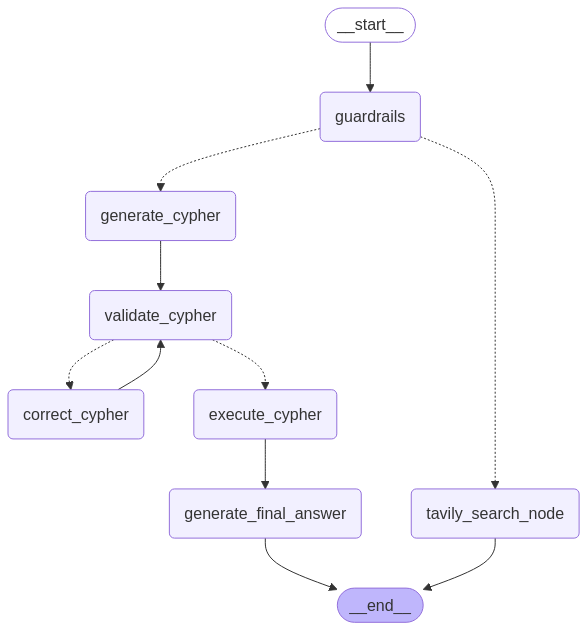

In [218]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph

langgraph = StateGraph(State)
langgraph.add_node(guardrails)
langgraph.add_node(generate_cypher)
langgraph.add_node(tavily_search_node)
langgraph.add_node(validate_cypher)
langgraph.add_node(correct_cypher)
langgraph.add_node(execute_cypher)
langgraph.add_node(generate_final_answer)

langgraph.add_edge(START, "guardrails")
langgraph.add_conditional_edges(
    "guardrails",
    guardrails_condition,
)
langgraph.add_edge("tavily_search_node",END)
langgraph.add_edge("generate_cypher", "validate_cypher")
langgraph.add_conditional_edges(
    "validate_cypher",
    validate_cypher_condition,
)
langgraph.add_edge("execute_cypher", "generate_final_answer")
langgraph.add_edge("correct_cypher", "validate_cypher")
langgraph.add_edge("generate_final_answer", END)

langgraph = langgraph.compile(
    checkpointer=MemorySaver(),
)


display(Image(langgraph.get_graph().draw_mermaid_png()))

In [230]:
import uuid

thread_id = str(uuid.uuid4())

config = {"configurable": {"thread_id": thread_id,"force_refresh": str(uuid.uuid4())}}

In [233]:

user_input = "Who all acted in City Hall"



In [234]:
output = langgraph.invoke({"messages": [user_input]}, config)
generated_text = output["messages"][-1]

print(generated_text)

Al Pacino, Bridget Fonda, John Cusack, and Danny Aiello acted in City Hall. 

Al Pacino, Bridget Fonda, John Cusack, and Danny Aiello acted in City Hall. 



In [183]:
!pip install gradio

In [229]:
from flask import Flask
import gradio as gr

app = Flask(" ")

def process_text(text):

  output = langgraph.invoke({"messages": [user_input]}, config)
  generated_text = output["messages"][-1]
  return generated_text

@app.route('/')
def index():
    return "Flask server is running! Access Gradio at /gradio"

gr_interface = gr.Interface(
    fn=process_text,
    inputs=gr.Textbox(label="Enter Text"),
    outputs=gr.Textbox(label="Result"),
    title="Movie Database Query Engine",
    description=" "
)

gr_app = gr_interface.launch(server_name="0.0.0.0", share=True, inline=False)


app.run(debug=True, port=5000)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a2045e5b08af280671.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
 * Serving Flask app ' '
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


The genres for City Hall are Drama and Thriller. 

